In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scgen
from matplotlib import pyplot as plt
import os

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load the Dataset

In [5]:
SCRNA_DIR = '../data/scRNA/'

In [6]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 796 ms, sys: 1.51 s, total: 2.3 s
Wall time: 5.3 s


In [7]:
scrna

AnnData object with n_obs × n_vars = 53638 × 20287 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition', 'n_counts'
    var: 'gene_name', 'gene_id', 'exonLength'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

In [8]:
network = scgen.VAEArithKeras(scrna.shape[1], z_dimension=10, alpha=0.1, model_path='./models/scrna')

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20287)             0         
_________________________________________________________________
encoder (Model)              (None, 10)                16892020  
_________________________________________________________________
decoder (Model)              (None, 20287)             16904287  
Total params: 33,796,307
Trainable params: 33,789,907
Non-trainable params: 6,400
_________________________________________________________________


In [9]:
history = network.train(scrna, n_epochs=10, verbose=True, batch_size=128)


Epoch 1/10
53638/53638 [==============================] - 26s 476us/step - loss: 358.6894 - kl_loss: 45.7867 - recon_loss: 354.1108
Epoch 2/10
53638/53638 [==============================] - 30s 562us/step - loss: 323.0814 - kl_loss: 31.5691 - recon_loss: 319.9245
Epoch 3/10
53638/53638 [==============================] - 31s 570us/step - loss: 317.7150 - kl_loss: 28.2736 - recon_loss: 314.8877
Epoch 4/10
53638/53638 [==============================] - 30s 563us/step - loss: 314.1794 - kl_loss: 26.7737 - recon_loss: 311.5020
Epoch 5/10
53638/53638 [==============================] - 31s 569us/step - loss: 310.2524 - kl_loss: 24.6121 - recon_loss: 307.7911
Epoch 6/10
53638/53638 [==============================] - 27s 506us/step - loss: 307.5068 - kl_loss: 23.5276 - recon_loss: 305.1542
Epoch 7/10
53638/53638 [==============================] - 28s 517us/step - loss: 305.8139 - kl_loss: 23.1480 - recon_loss: 303.4991
Epoch 8/10
53638/53638 [==============================] - 27s 504us/step - 

In [10]:
adata = scrna

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

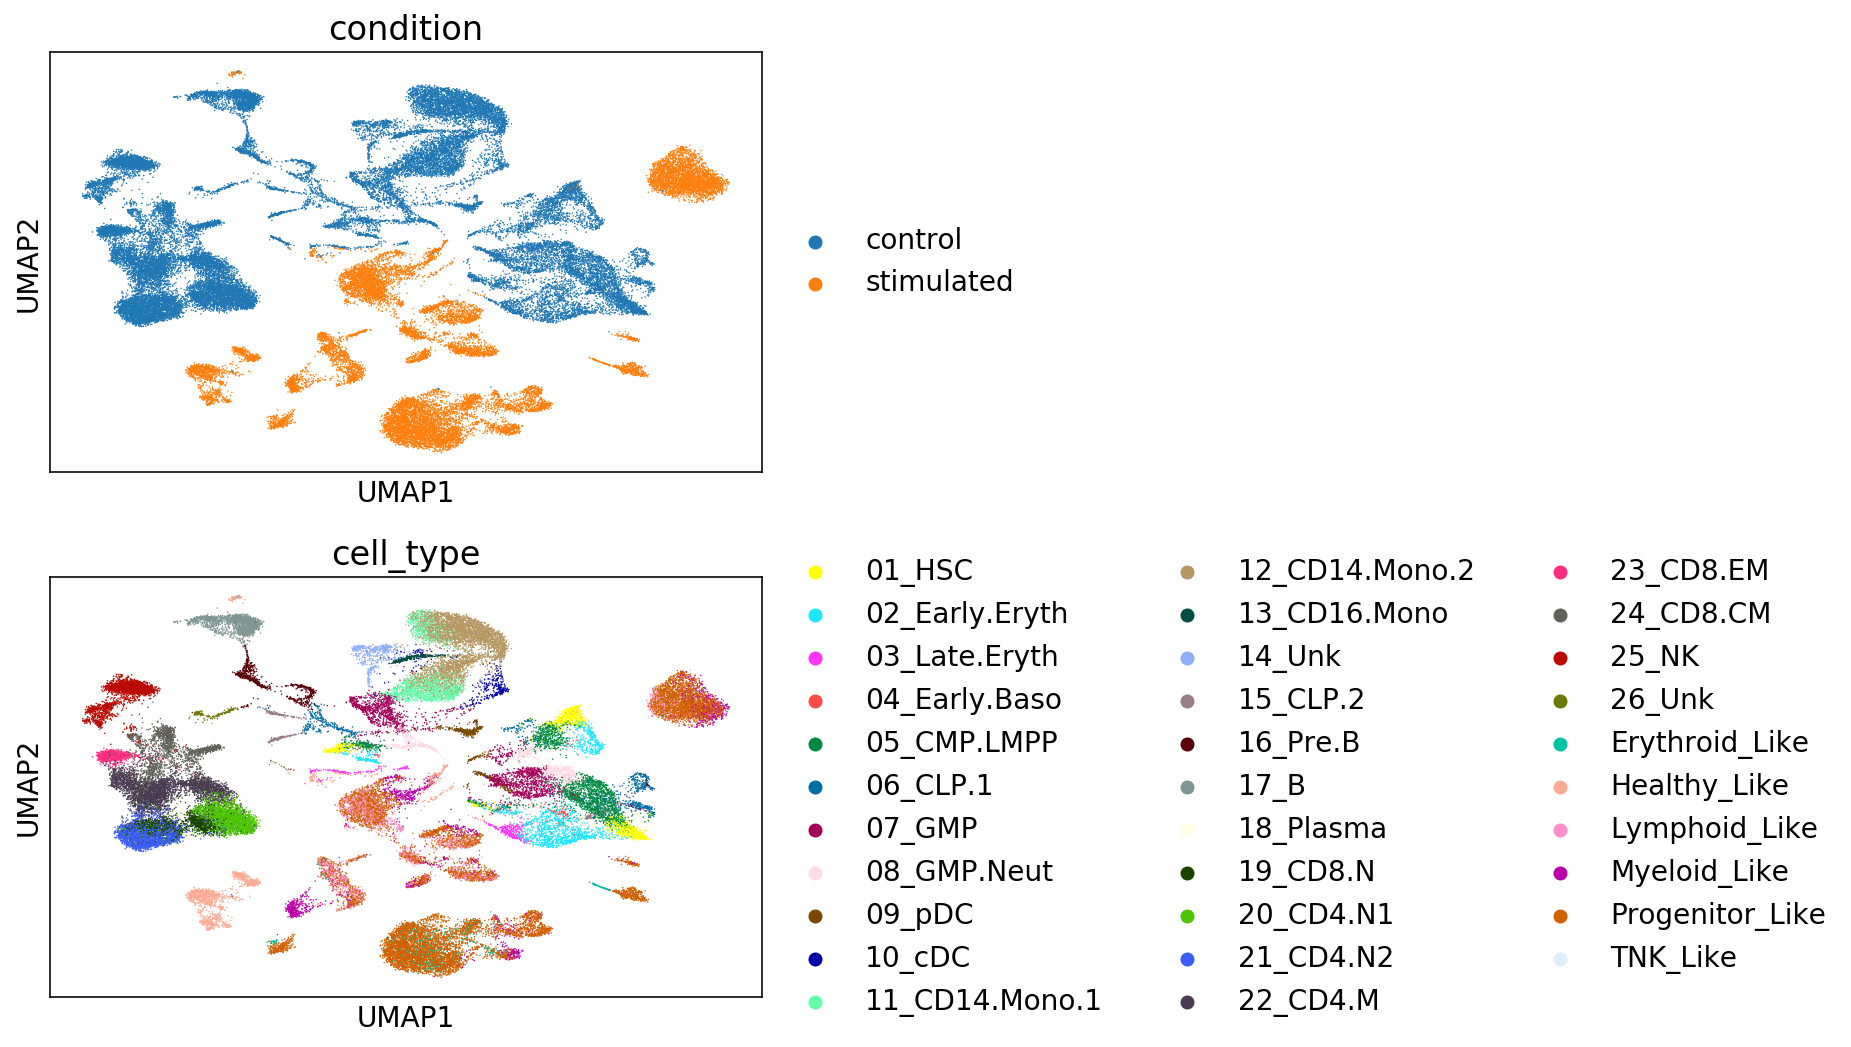

In [11]:
sc.pp.neighbors(adata, random_state=42)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color=['condition', 'cell_type'], ncols=1)

In [18]:
adata_latent = network.to_latent(adata.X)
adata_latent = sc.AnnData(adata_latent)
adata_latent.obs = adata.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


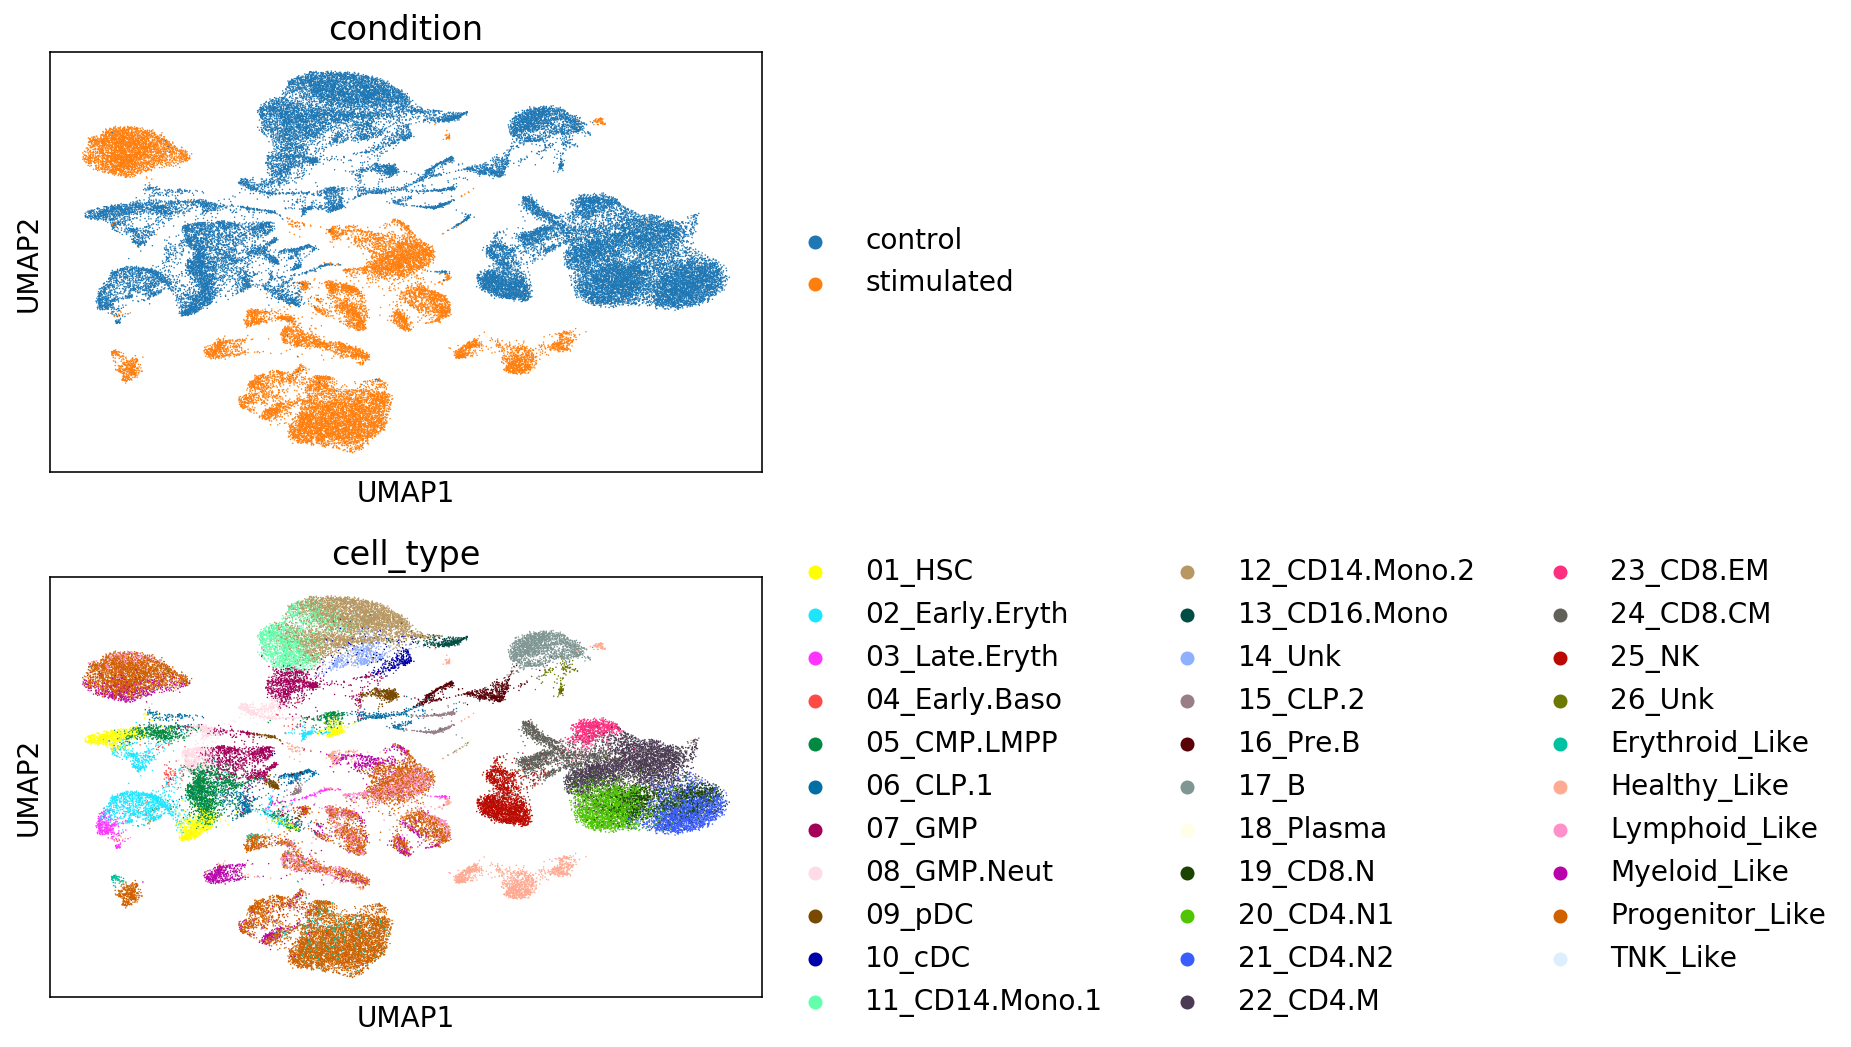

In [19]:
sc.pp.neighbors(adata_latent, random_state=42)
sc.tl.umap(adata_latent, random_state=42)
sc.pl.umap(adata_latent, color=['condition', 'cell_type'], ncols=1)

In [20]:
delta = np.mean(adata_latent[adata_latent.obs['condition'] == 'stimulated'].X, axis=0, keepdims=True) - \
        np.mean(adata_latent[adata_latent.obs['condition'] == 'control'].X, axis=0, keepdims=True)
delta

ArrayView([[ 1.0053993 , -0.05682036, -0.04831739,  0.46068466,
            -0.7017312 ,  0.75745064, -0.11745843,  0.10765599,
             1.598986  ,  0.04650228]], dtype=float32)

In [21]:
adata_latent[adata_latent.obs['condition'] == 'control'].X += delta

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


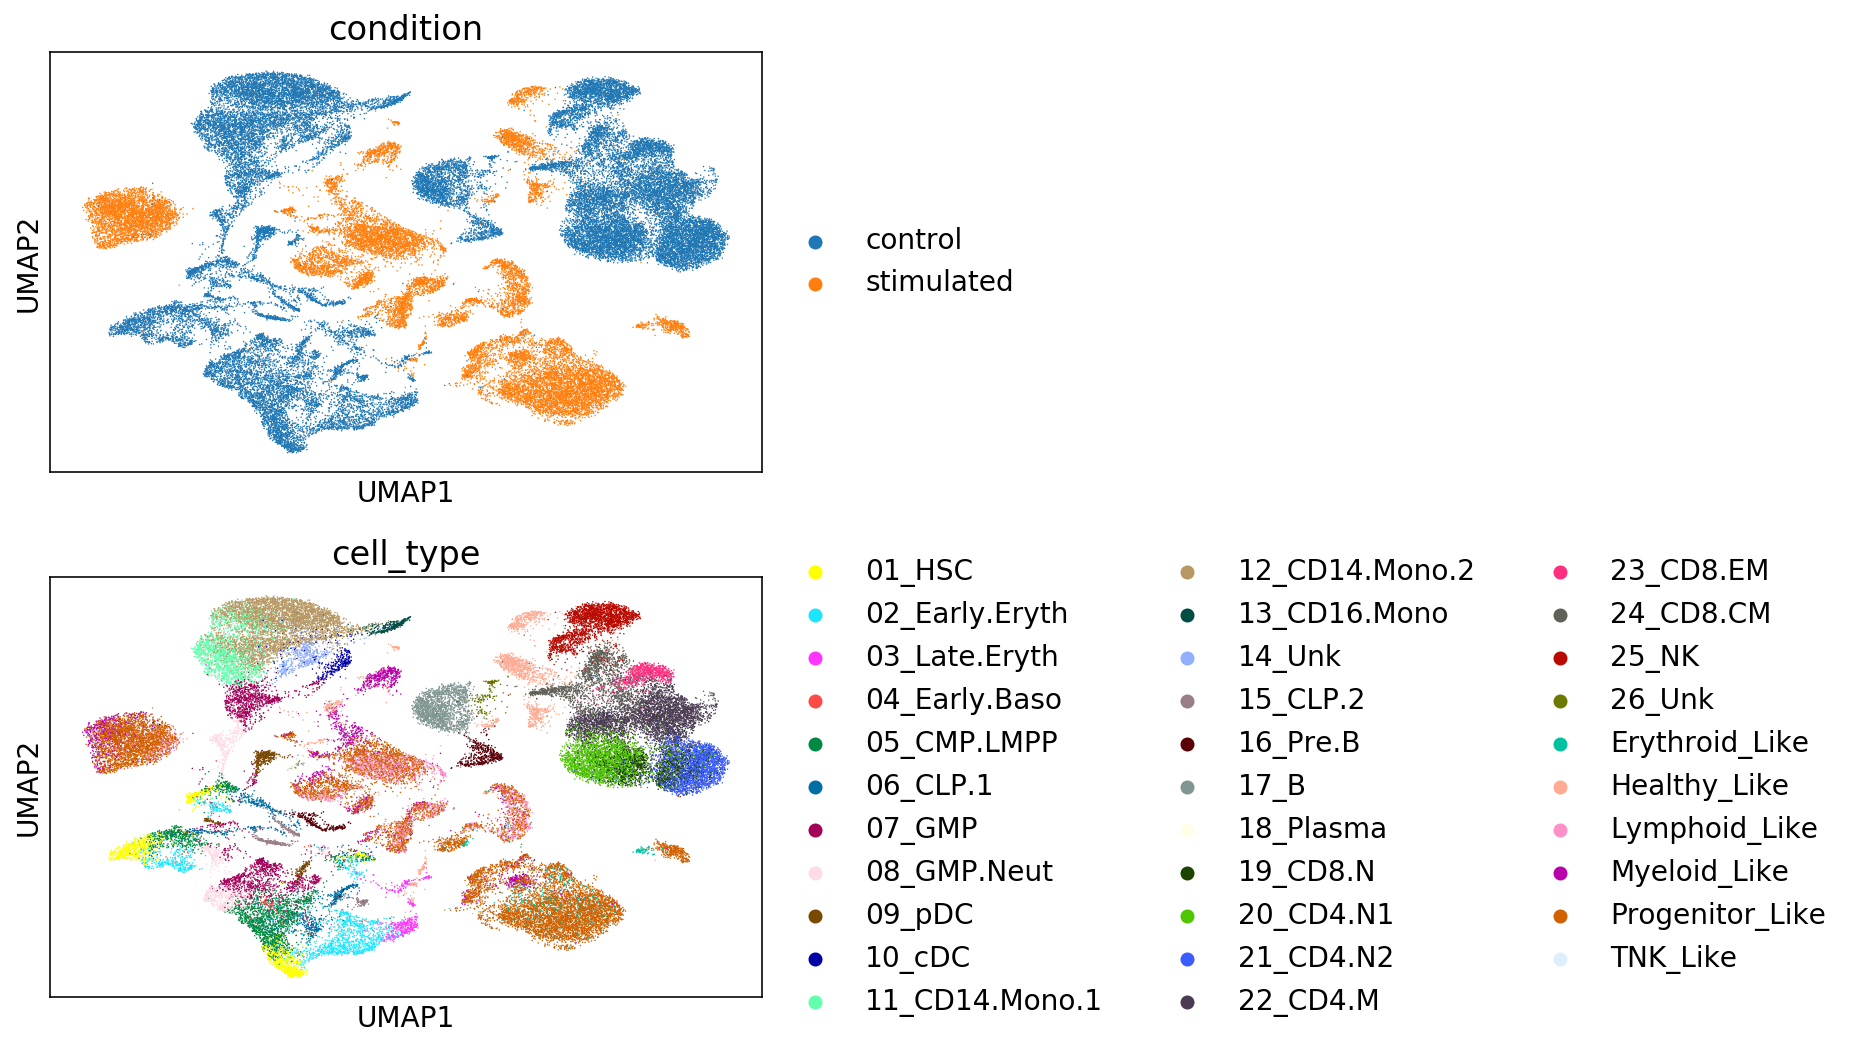

In [22]:
sc.pp.neighbors(adata_latent, random_state=42)
sc.tl.umap(adata_latent, random_state=42)
sc.pl.umap(adata_latent, color=['condition', 'cell_type'], ncols=1)